In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('good_villages.txt') as f:
    words = f.read().splitlines()

In [3]:
vocab = sorted(list(set(''.join(words))))

In [4]:
print(vocab)

[' ', "'", '-', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я', 'є', 'і', 'ї', 'ґ']


In [5]:
len(words)

14349

In [6]:
import random
random.sample(words, 10)

['запорізька балка',
 'кадомка',
 'ільці',
 'луцики',
 'володимирка',
 'товарна',
 'студенок',
 'скаливатка',
 'саїнка',
 'підгаття']

In [7]:
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0

itos = {v: k for k, v in stoi.items()}
vocab_size = len(itos)

In [8]:
vocab_size

37

In [9]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        for char in word + '.':
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [10]:
Xtr.shape, Xte.shape, Xdev.shape

(torch.Size([113807, 3]), torch.Size([14180, 3]), torch.Size([14308, 3]))

In [12]:
n_emb = 10
n_hidden = 200

C = torch.randn(vocab_size, n_emb              ) 
W1 = torch.rand((block_size * n_emb, n_hidden) ) * (5/3)/(block_size * n_emb)**0.5
b1 = torch.rand(n_hidden                       ) * 0.01
W2 = torch.randn(n_hidden, vocab_size          ) * 0.01
b2 = torch.rand(vocab_size                     ) * 0

params = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

14007


In [13]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward
    emb = C[Xb]
    emb_cat = emb.view(-1, n_emb * block_size)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in params:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01 if i < 100_000 else 0.01
    for p in params:
        p.data += -lr * p.grad
    
    # stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

      0/ 200000: 3.6847
  10000/ 200000: 2.4515
  20000/ 200000: 2.4483
  30000/ 200000: 2.0541
  40000/ 200000: 2.0454
  50000/ 200000: 2.3879
  60000/ 200000: 2.1486
  70000/ 200000: 1.8158
  80000/ 200000: 2.1421
  90000/ 200000: 2.0377
 100000/ 200000: 1.9131
 110000/ 200000: 1.9064
 120000/ 200000: 2.1009
 130000/ 200000: 1.3436
 140000/ 200000: 2.3263
 150000/ 200000: 1.8172
 160000/ 200000: 1.6496
 170000/ 200000: 1.8279
 180000/ 200000: 1.6283
 190000/ 200000: 1.5642


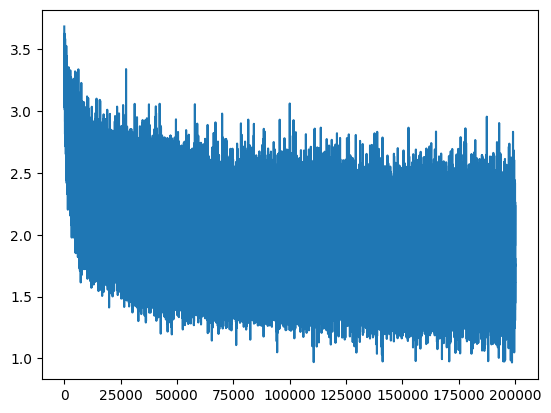

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad()
def split_loss(split: str):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    emb = C[x]
    emb_cat = emb.view(-1, n_emb * block_size)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.812497854232788
val 1.8776651620864868


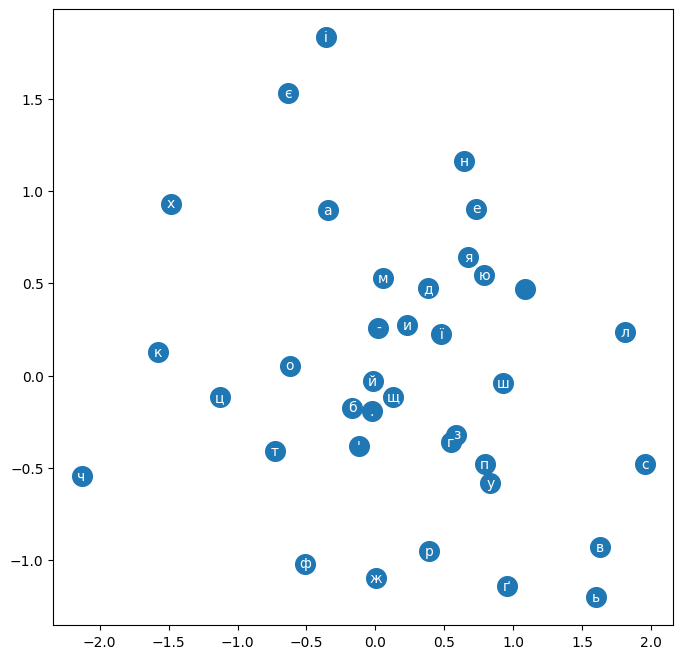

In [55]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,4].data, s=200)

for i in range((C.shape[0])):
    plt.text(C[i,0].item(), C[i,4].item(), itos[i], ha='center', va='center', color='white')

In [16]:
def sample(n_samples, start=None):
    out_ = []
    while len(out_) < n_samples:
        out = []
        if start is None:
            context = [0] * block_size
        else:
            context = [stoi[s] for s in start]
        while True:
            emb = C[torch.tensor(context)]
            emb_cat = emb.view(-1, n_emb * block_size)
            hpreact = emb_cat @ W1 + b1
            h = torch.tanh(hpreact)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            if ix == 0:
                break
            context = context[1:] + [ix]
            out.append(itos[ix])
        if out not in out_:
            out_.append(out)
    for out in out_:
        if start is not None:
            print(start + ''.join(out))
        else:
            print(''.join(out))

In [20]:
sample(10, 'гор')

городеррибятій
гороблаболданченкуважів
горське
горіжня селиків
горинограбанків
горбівка
горокозарщина
горик
городнопили
гори
